# Method development for geometric functions

- 09/04/20 (post-debug)
- 26/02/20 v1

Aims:

- Develop $\beta_{L,M}$ formalism.
- Develop corresponding numerical methods.
- Speed things up (see [low-level benchmarking notebook](https://epsproc.readthedocs.io/en/dev/tests/Low_level_bench_tests_Wigner3j_Feb2020.html)).
- Analyse geometric terms.

## Setup

In [1]:
# Imports
import numpy as np
import pandas as pd
import xarray as xr
from functools import lru_cache  # For function result caching

# Special functions
# from scipy.special import sph_harm
import spherical_functions as sf
import quaternion

# Performance & benchmarking libraries
# from joblib import Memory
# import xyzpy as xyz
import numba as nb

# Timings with ttictoc
# https://github.com/hector-sab/ttictoc
# from ttictoc import TicToc

# Package fns.
# For module testing, include path to module here
import sys
import os
modPath = r'D:\code\github\ePSproc'  # Win test machine
# modPath = r'/home/femtolab/github/ePSproc/'  # Linux test machine
sys.path.append(modPath)
import epsproc as ep
# TODO: tidy this up!

# Direct imports for dev functions
from epsproc.util import matEleSelector
from epsproc.geomFunc import geomCalc
import epsproc._sns_matrixMod as snsMatMod  # Seaborn (SNS) code with modified clustermap function - see https://github.com/mwaskom/seaborn/pull/1393 

* pyevtk not found, VTK export not available. 


## Exploring Wigner 3js

In photoionization calculations, there is a lot of angular momentum coupling to deal with. Typically, 4 to 6 Wigner 3j terms appear (depending on the formalism), and/or higher-order terms in cases where couplings are included.

\begin{equation}
W = \left(\begin{array}{ccc}
l & l' & L\\
m & m' & M
\end{array}\right)
\end{equation}

Since this is, effectively, a 6D space, dimensions $(l_{max}, l_{max}, 2l_{max}, 2l_{max}+1, 2l_{max}+1, 4l_{max}+1)$ things can get large quickly. For small $l_{max}$ it's easy to look at some values directly...

(For more details on [3j symbols, see Wikipedia](https://en.wikipedia.org/wiki/3-j_symbol) and [Wolfram Mathworld](https://mathworld.wolfram.com/Wigner3j-Symbol.html); for more on the numerics, see the [test notebook](https://epsproc.readthedocs.io/en/latest/tests/Spherical_function_testing_Aug_2019.html), and [benchmarks](https://epsproc.readthedocs.io/en/latest/tests/Low_level_bench_tests_Wigner3j_Feb2020.html).)

TODO: test numerically some of the symmetry properties here, by summation.

In [2]:
# Calculate some values.
# w3jTable will output all values up to l=lp=Lmax (hence L=2Lmax)
lmax = 1
w3jlist = geomCalc.w3jTable(Lmax = lmax, form = '2d', nonzeroFlag = True)  # For form = '2d', nonzeroFlag = True: the function will output only valid entries as a coordinate table

print(w3jlist.shape)
print(f'Max value: {w3jlist[:,-1].max()}, min value: {w3jlist[:,-1].min()}\n')

# Print part of the table - output format has rows (l, lp, L, m, mp, M, 3j)
print(w3jlist)

(25, 7)
Max value: 1.0, min value: -0.5773502691896257

[[ 0.          0.          0.          0.          0.          0.
   1.        ]
 [ 0.          1.          1.          0.         -1.          1.
   0.57735027]
 [ 0.          1.          1.          0.          0.          0.
  -0.57735027]
 [ 0.          1.          1.          0.          1.         -1.
   0.57735027]
 [ 1.          0.          1.         -1.          0.          1.
   0.57735027]
 [ 1.          0.          1.          0.          0.          0.
  -0.57735027]
 [ 1.          0.          1.          1.          0.         -1.
   0.57735027]
 [ 1.          1.          2.         -1.         -1.          2.
   0.4472136 ]
 [ 1.          1.          1.         -1.          0.          1.
   0.40824829]
 [ 1.          1.          2.         -1.          0.          1.
  -0.31622777]
 [ 1.          1.          0.         -1.          1.          0.
   0.57735027]
 [ 1.          1.          1.         -1.          1.

Number of valid (non-NaN) elements: <xarray.DataArray 'w3jStacked' ()>
array(25)
Plotting data (No filename), pType=r, thres=0.01, with Seaborn


C:\Users\femtolab\.conda\envs\ePSdev\lib\site-packages\xarray\core\nputils.py:215: RuntimeWarning:

All-NaN slice encountered



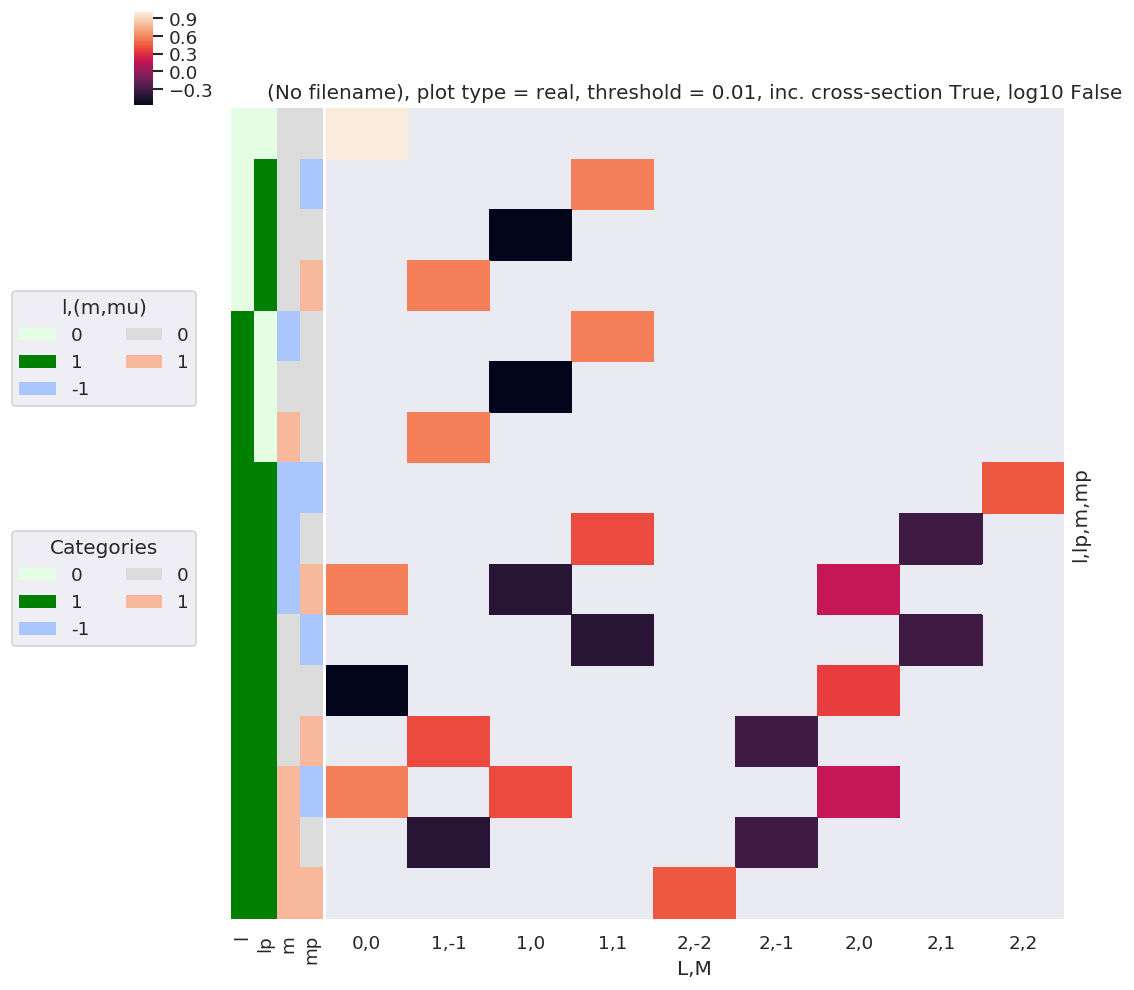

In [3]:
# Recalculate and set to Xarray output format, then plot with ep.lmPlot()

w3j = geomCalc.w3jTable(Lmax = lmax, form = 'xdaLM', nonzeroFlag = True)

# Check number of valid entries matches basic table above
# print(f'Number of valid (non-NaN) elements: {w3j.count()}')
print(f'Number of valid (non-NaN) elements: {w3j.notnull().sum()}')

# Set parameters to restack the Xarray into (L,M) pairs
xDim = {'LM':['L','M']}

# Plot with ep.lmPlot(), real values
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(w3j, xDim=xDim, pType = 'r')

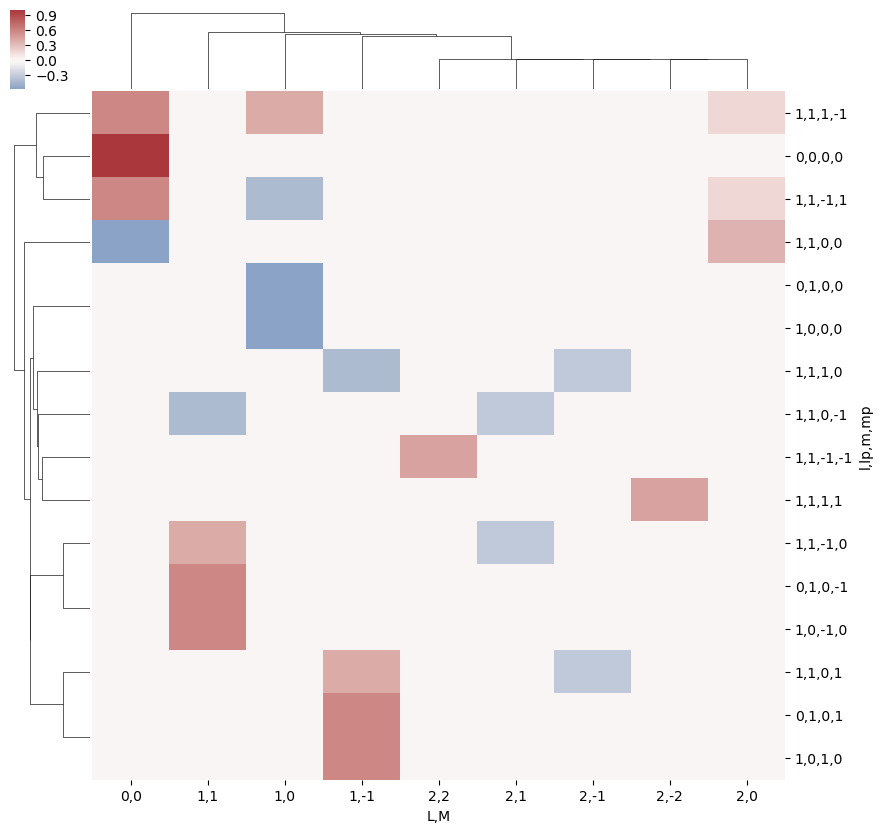

In [4]:
# A complementary visulization is to call directly the sns.clustermap plot, use clustering and plot by category labels - see https://seaborn.pydata.org/index.html
# (ep.lpPlot uses a modified version of this routine.)
ep.basicPlotters.snsMatMod.clustermap(daPlotpd.fillna(0), center=0, cmap="vlag", row_cluster=True, col_cluster=True)

In [5]:
# Print out values by QNs (Pandas table)
daPlotpd

L                 0         1                             2            \
M                 0        -1         0         1        -2        -1   
l lp m  mp                                                              
0 0   0  0  1.00000       NaN       NaN       NaN       NaN       NaN   
  1   0 -1      NaN       NaN       NaN  0.577350       NaN       NaN   
         0      NaN       NaN -0.577350       NaN       NaN       NaN   
         1      NaN  0.577350       NaN       NaN       NaN       NaN   
1 0  -1  0      NaN       NaN       NaN  0.577350       NaN       NaN   
      0  0      NaN       NaN -0.577350       NaN       NaN       NaN   
      1  0      NaN  0.577350       NaN       NaN       NaN       NaN   
  1  -1 -1      NaN       NaN       NaN       NaN       NaN       NaN   
         0      NaN       NaN       NaN  0.408248       NaN       NaN   
         1  0.57735       NaN -0.408248       NaN       NaN       NaN   
      0 -1      NaN       NaN       NaN -0.408248       NaN       NaN   
         0 -0.57735       NaN       NaN       NaN       NaN       NaN   
         1      NaN  0.408248       NaN       NaN       NaN -0.316228   
      1 -1  0.57735       NaN  0.408248       NaN       NaN       NaN   
         0      NaN -0.408248       NaN       NaN       NaN -0.316228   
         1      NaN       NaN       NaN       NaN  0.447214       NaN   

L                                         
M                  0         1         2  
l lp m  mp                                
0 0   0  0       NaN       NaN       NaN  
  1   0 -1       NaN       NaN       NaN  
         0       NaN       NaN       NaN  
         1       NaN       NaN       NaN  
1 0  -1  0       NaN       NaN       NaN  
      0  0       NaN       NaN       NaN  
      1  0       NaN       NaN       NaN  
  1  -1 -1       NaN       NaN  0.447214  
         0       NaN -0.316228       NaN  
         1  0.182574       NaN       NaN  
      0 -1       NaN -0.316228       NaN  
         0  0.365148       NaN       NaN  
         1       NaN       NaN       NaN  
      1 -1  0.182574       NaN       NaN  
         0       NaN       NaN       NaN  
         1       NaN       NaN       NaN

This ends up as a relatively sparse array, since many combinations are invalid (do not follow angular momentum selection rules), hence there are many NaN terms.

The results can also be output as a 6D sparse array, using the [Sparse library](https://sparse.pydata.org/en/latest/index.html).

In [6]:
# Calculate and output in Sparse array format
w3jSparse = geomCalc.w3jTable(Lmax = lmax, form = 'ndsparse')
w3jSparse

Format,coo
Data Type,float64
Shape,"(2, 2, 3, 2, 2, 3)"
nnz,57
Density,0.3958333333333333
Read-only,True
Size,3.1K
Storage ratio,2.8


Here `nnz` is the number of non-zero elements.

Number of valid (non-NaN) elements: <xarray.DataArray 'w3jStacked' ()>
array(7056)
Plotting data (No filename), pType=r, thres=0.01, with Seaborn


C:\Users\femtolab\.conda\envs\ePSdev\lib\site-packages\xarray\core\nputils.py:215: RuntimeWarning:

All-NaN slice encountered



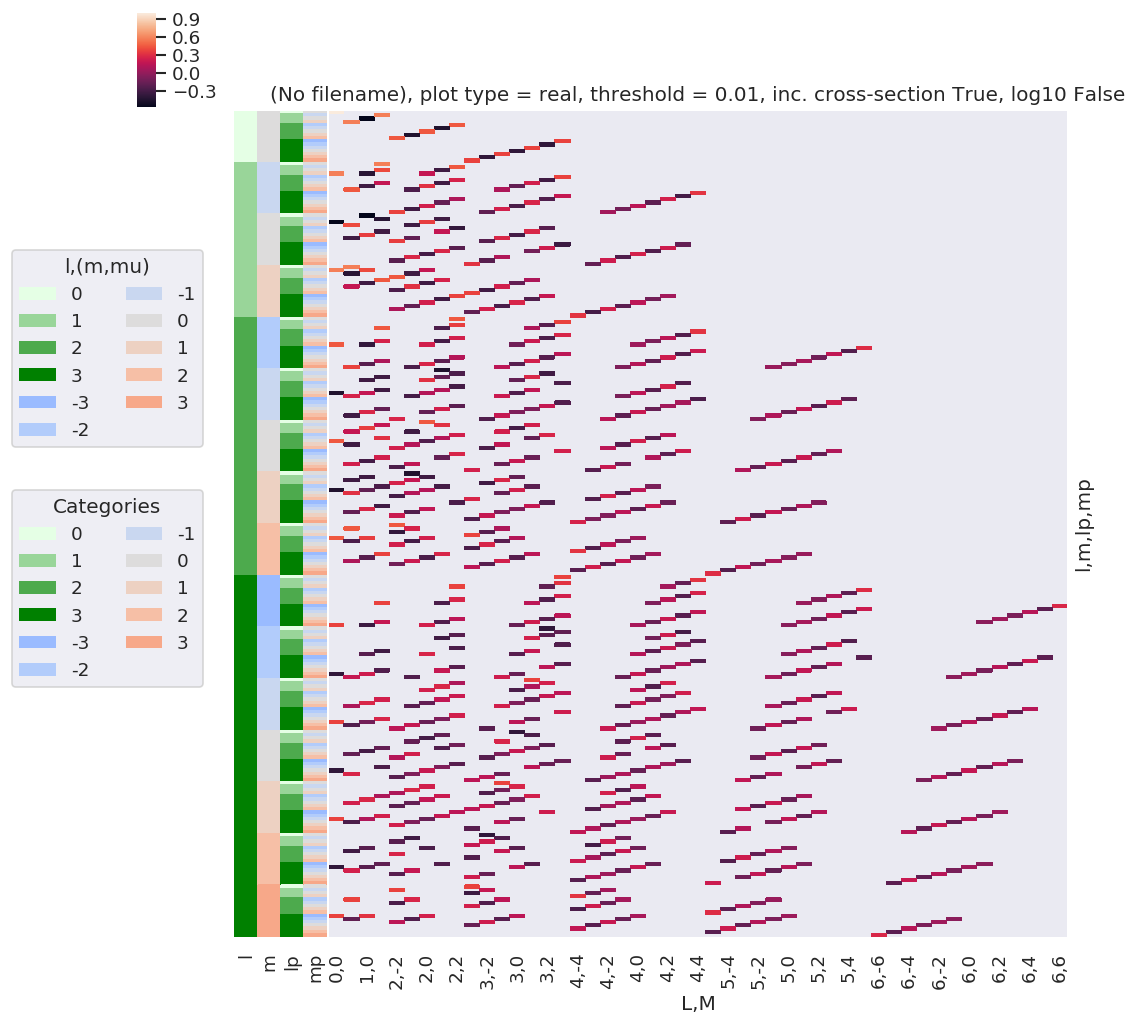

In [7]:
# Try a larger Lmax and plot only.
lmax = 3
w3j = geomCalc.w3jTable(Lmax = lmax, form = 'xdaLM')

# Check number of valid entries matches basic table above
print(f'Number of valid (non-NaN) elements: {w3j.count()}')

# Set parameters to restack the Xarray into (L,M) pairs
plotDimsRed = ['l', 'm', 'lp', 'mp']
xDim = {'LM':['L','M']}

# Plot with ep.lmPlot(), real values
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(w3j, plotDims=plotDimsRed, xDim=xDim, pType = 'r')

C:\Users\femtolab\.conda\envs\ePSdev\lib\site-packages\xarray\core\nputils.py:215: RuntimeWarning:

All-NaN slice encountered



Plotting data (No filename), pType=r, thres=0.01, with Seaborn


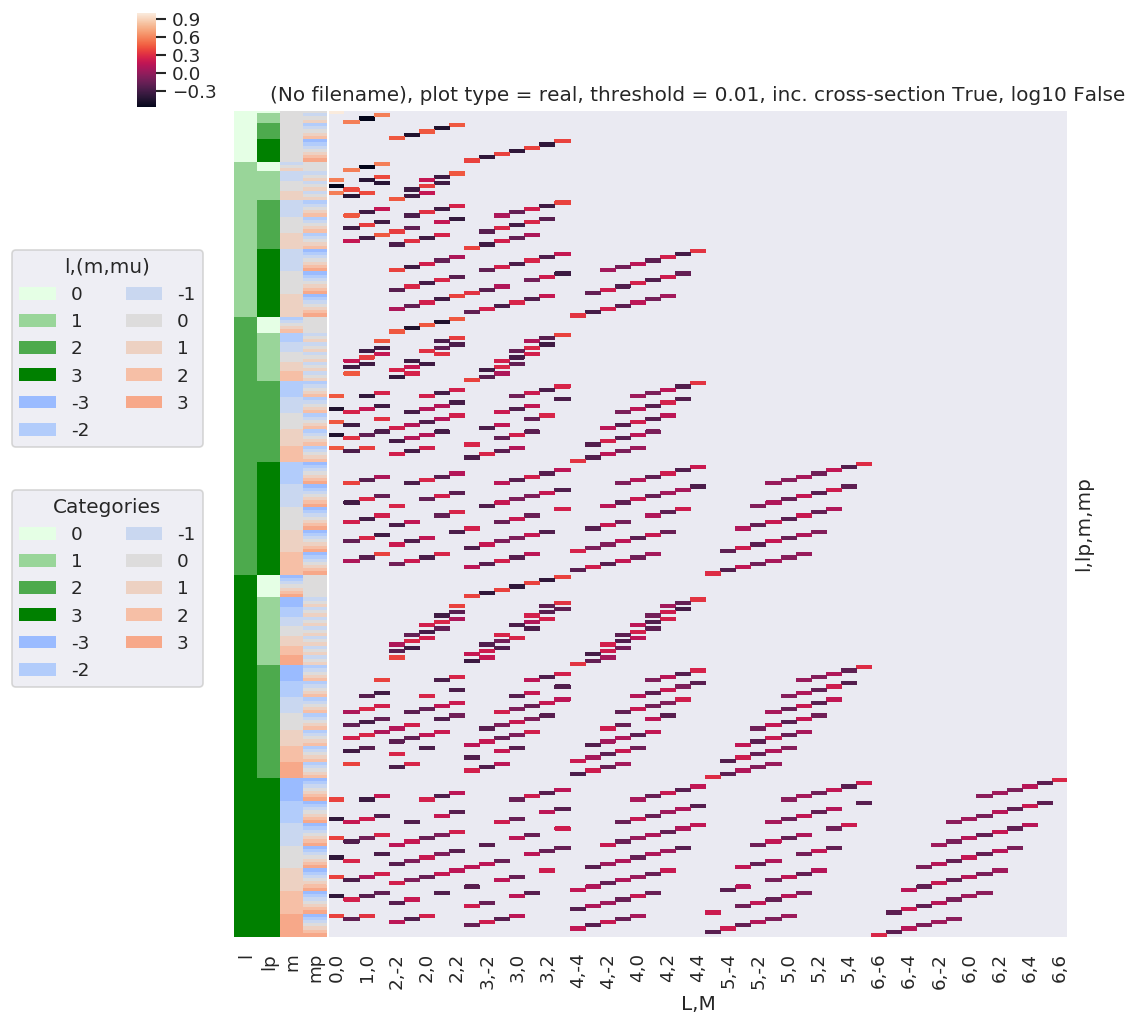

In [8]:
# Resort axis by (l,lp)
plotDimsRed = ['l', 'lp', 'm', 'mp']
xDim = {'LM':['L','M']}

# Plot with ep.lmPlot(), real values
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(w3j, plotDims=plotDimsRed, xDim=xDim, pType = 'r')

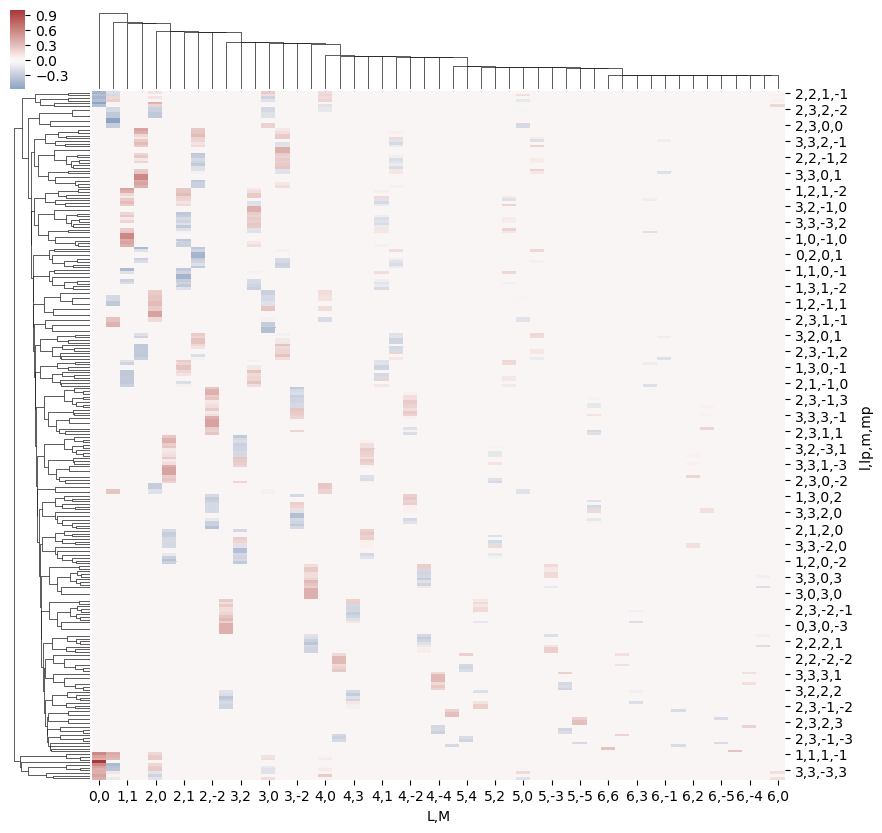

In [9]:
# A complementary visulization is to call directly the sns.clustermap plot, use clustering and plot by category labels - see https://seaborn.pydata.org/index.html
# (ep.lpPlot uses a modified version of this routine.)
snsMatMod.clustermap(daPlotpd.fillna(0), center=0, cmap="vlag", row_cluster=True, col_cluster=True)

This clearly shows that the valid terms become sparser at higher $l$, and the couplings become smaller.

Structure can also be examined using other methods, e.g. correlation functions (see, for example, [Seaborn Discovering structure in heatmap data](https://seaborn.pydata.org/examples/structured_heatmap.html). The example here shows [Panda's standard Pearson correlation coefficient](https://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#correlation), which may (or may not) be particularly meaningful here... but does show structures.

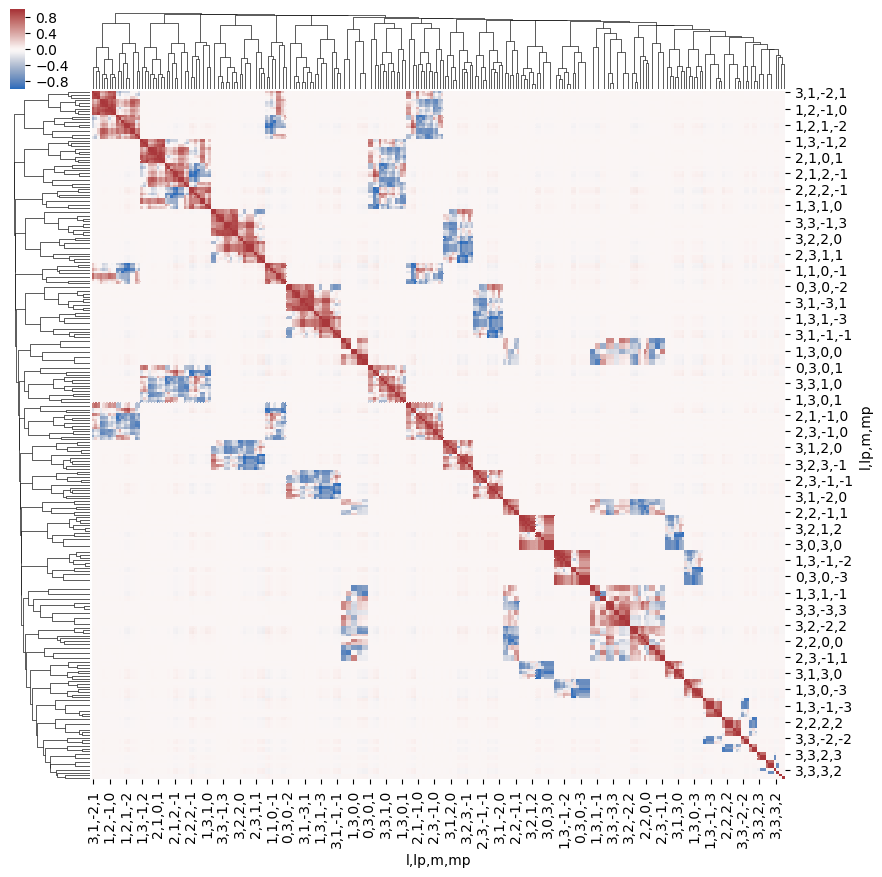

In [10]:
snsMatMod.clustermap(daPlotpd.fillna(0).T.corr(), center=0, cmap="vlag", row_cluster=True, col_cluster=True)

C:\Users\femtolab\.conda\envs\ePSdev\lib\site-packages\xarray\core\nputils.py:215: RuntimeWarning:

All-NaN slice encountered



Plotting data (No filename), pType=r, thres=0.01, with Seaborn


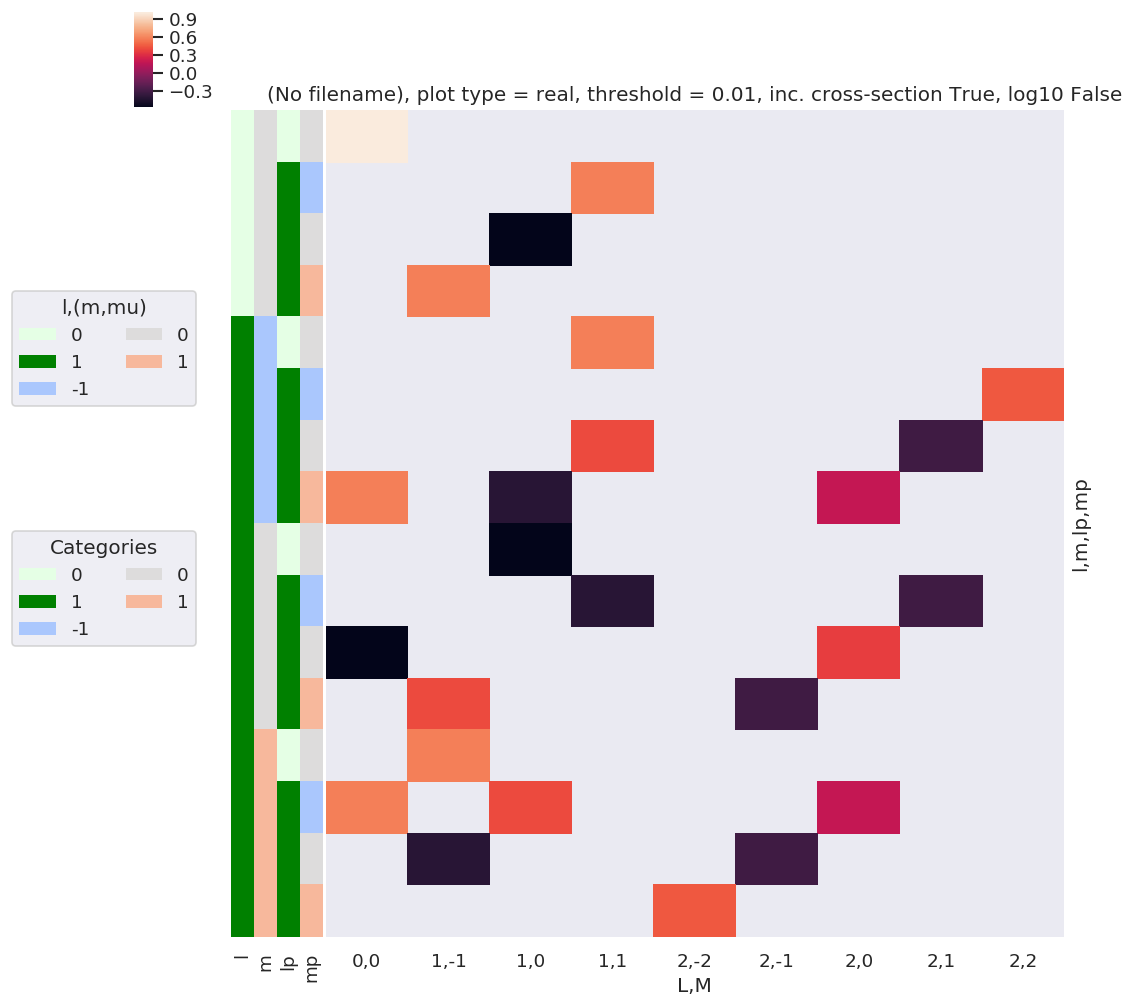

In [11]:
# Test some other Seaborn methods... these likely won't scale well for large lmax!
import seaborn as sns

# Recalculate for small lmax
lmax = 1
w3j = geomCalc.w3jTable(Lmax = lmax, form = 'xdaLM')

# Set parameters to restack the Xarray into (L,M) pairs
plotDimsRed = ['l', 'm', 'lp', 'mp']
xDim = {'LM':['L','M']}

# Plot with ep.lmPlot(), real values
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(w3j, plotDims=plotDimsRed, xDim=xDim, pType = 'r')

# Try sns pairplot
# sns.pairplot(daPlotpd.fillna(0).T)  # Big grids!
# sns.pairplot(daPlotpd.fillna(0))  # OK, not particularly informative
# sns.pairplot(daPlotpd.fillna(0), hue = 'l')  # Doesn't work - multindex issue?

## $E_{P,R}$ tensor

The coupling of two 1-photon terms can be written as a tensor contraction:

\begin{equation}
E_{PR}(\hat{e})=[e\otimes e^{*}]_{R}^{P}=[P]^{\frac{1}{2}}\sum_{p}(-1)^{R}\left(\begin{array}{ccc}
1 & 1 & P\\
p & R-p & -R
\end{array}\right)e_{p}e_{R-p}^{*}\label{eq:EPR-defn-1}
\end{equation}

Where $e_{p}$ and $e_{R-p}$ define the field strengths for the polarizations $p$ and $R-p$, which are coupled into the spherical tensor $E_{PR}$.

(To derive this result, one can start from, e.g., Eq. 5.40 in Zare

\begin{equation}
[A^{(1)}\otimes B^{(1)}]_{q}^{k}=\sum_{m}\langle1m,1q-m|kq\rangle A(1,m)B(1,q-m)
\end{equation}

Convert to $3j$ form:

\begin{equation}
[A^{(1)}\otimes B^{(1)}]_{q}^{k}=\sum_{m}(-1)^{q}[k]^{1/2}\left(\begin{array}{ccc}
1 & 1 & k\\
m & q-m & -q
\end{array}\right)A(1,m)B(1,q-m)
\end{equation}

And substitute in appropriate terms.)

In [12]:
# Calculate EPR terms, all QNs, with field strengths e = 1
EPRtable = geomCalc.EPR(form = '2d')

# Output values as list, [l, lp, P, p, R-p, R, EPR]
print(EPRtable)

[[ 1.          1.          0.         -1.          1.          0.
   0.57735027]
 [ 1.          1.          1.         -1.          0.          1.
  -0.70710678]
 [ 1.          1.          1.         -1.          1.          0.
  -0.70710678]
 [ 1.          1.          2.         -1.         -1.          2.
   1.        ]
 [ 1.          1.          2.         -1.          0.          1.
   0.70710678]
 [ 1.          1.          2.         -1.          1.          0.
   0.40824829]
 [ 1.          1.          0.          0.          0.          0.
  -0.57735027]
 [ 1.          1.          1.          0.         -1.          1.
   0.70710678]
 [ 1.          1.          1.          0.          1.         -1.
  -0.70710678]
 [ 1.          1.          2.          0.         -1.          1.
   0.70710678]
 [ 1.          1.          2.          0.          0.          0.
   0.81649658]
 [ 1.          1.          2.          0.          1.         -1.
   0.70710678]
 [ 1.          1.          0

As before, we can visualise these values...

Plotting data (No filename), pType=r, thres=0.01, with Seaborn
Set dataType (No dataType)
Plotting data (No filename), pType=r, thres=0.01, with Seaborn


No handles with labels found to put in legend.


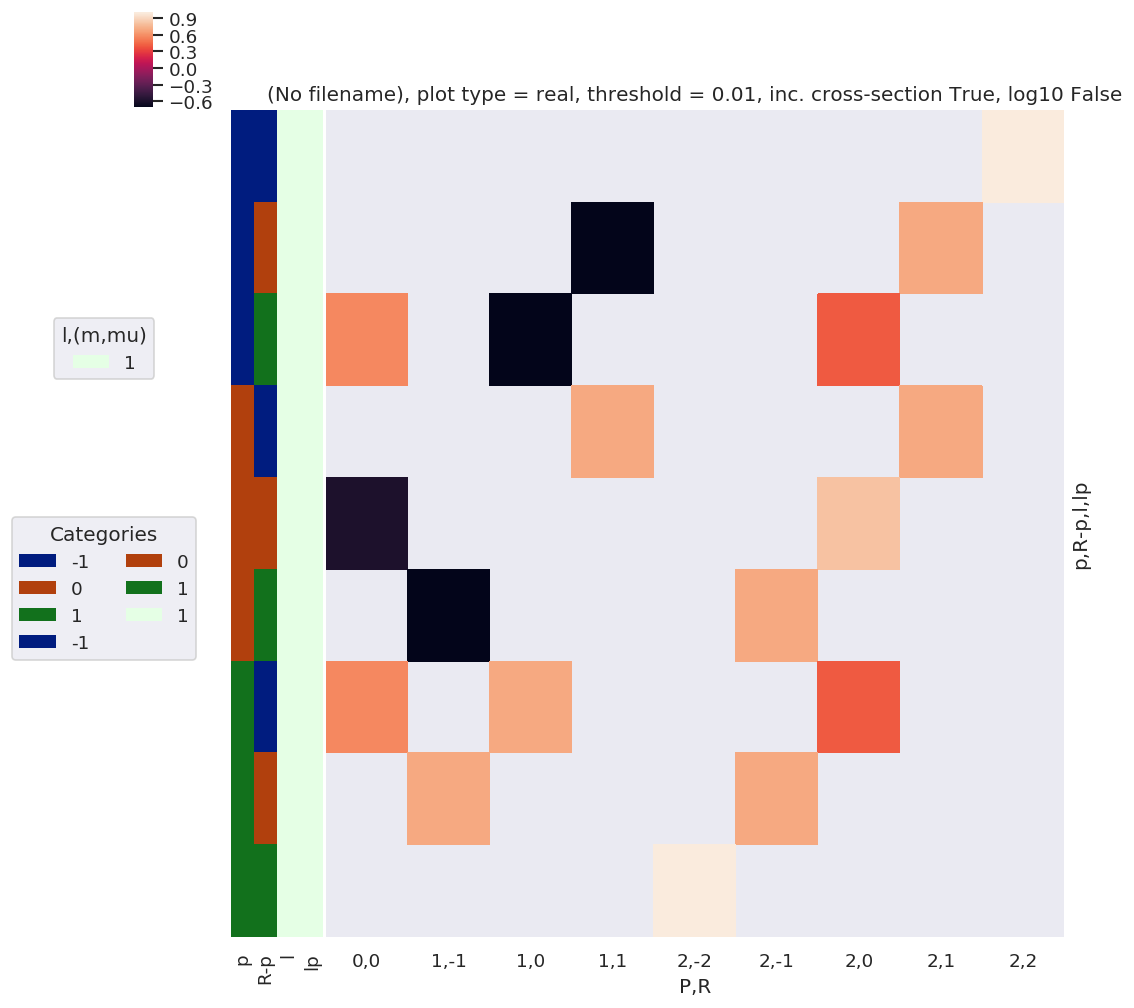

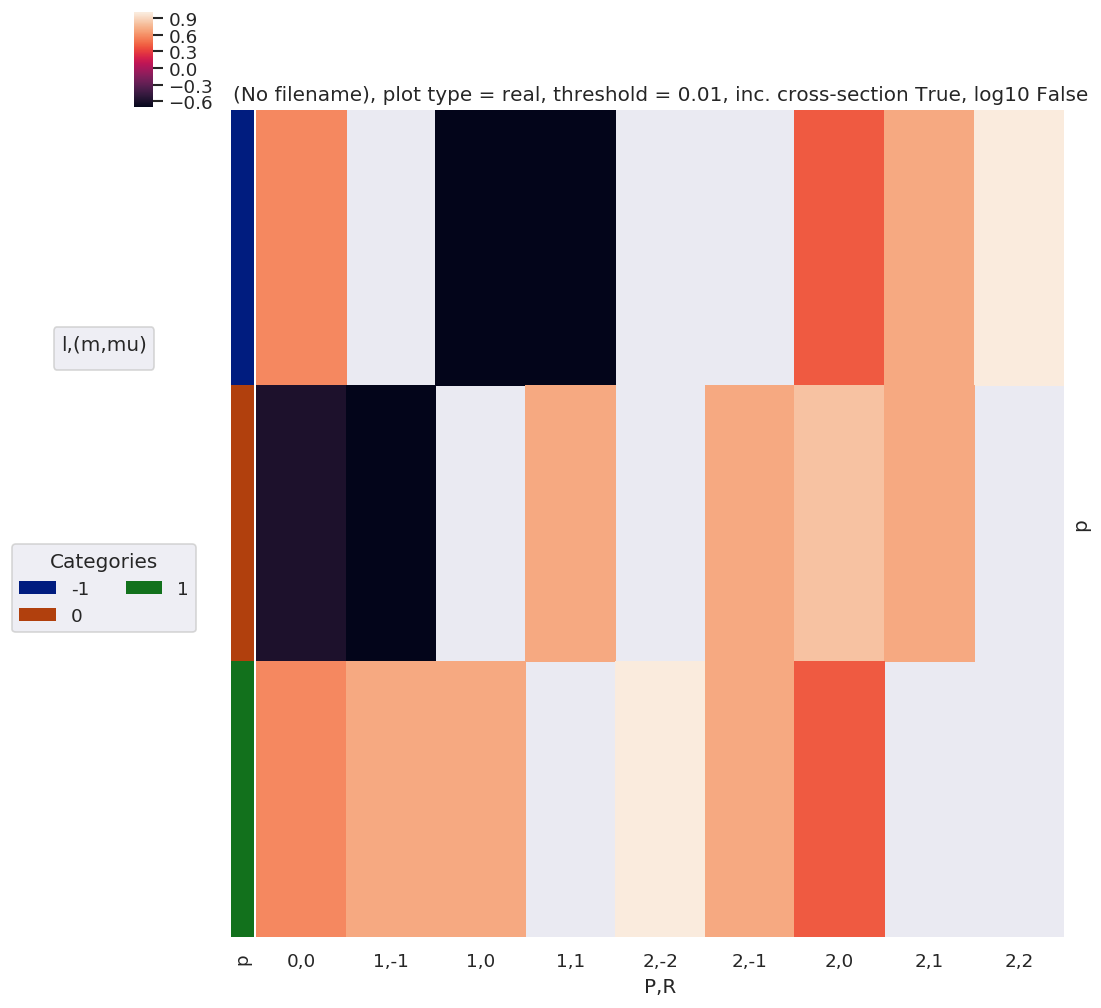

In [13]:
EPRX = geomCalc.EPR(form = 'xarray')

# Set parameters to restack the Xarray into (L,M) pairs
# plotDimsRed = ['l', 'p', 'lp', 'R-p']
plotDimsRed = ['p', 'R-p']
xDim = {'PR':['P','R']}

# Plot with ep.lmPlot(), real values
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(EPRX, plotDims=plotDimsRed, xDim=xDim, pType = 'r')
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(EPRX.unstack().sum(['l','lp','R-p']), xDim=xDim, pType = 'r')

# Seem to have some all-NaN cols persisting here, not sure why...

In [14]:
# Tabulate
daPlotpd.dropna(axis = 1, how = 'all')

P         0         1                        2                                \
R         0        -1         0         1   -2        -1         0         1   
p                                                                              
-1  0.57735       NaN -0.707107 -0.707107  NaN       NaN  0.408248  0.707107   
 0 -0.57735 -0.707107       NaN  0.707107  NaN  0.707107  0.816497  0.707107   
 1  0.57735  0.707107  0.707107       NaN  1.0  0.707107  0.408248       NaN   

P        
R     2  
p        
-1  1.0  
 0  NaN  
 1  NaN

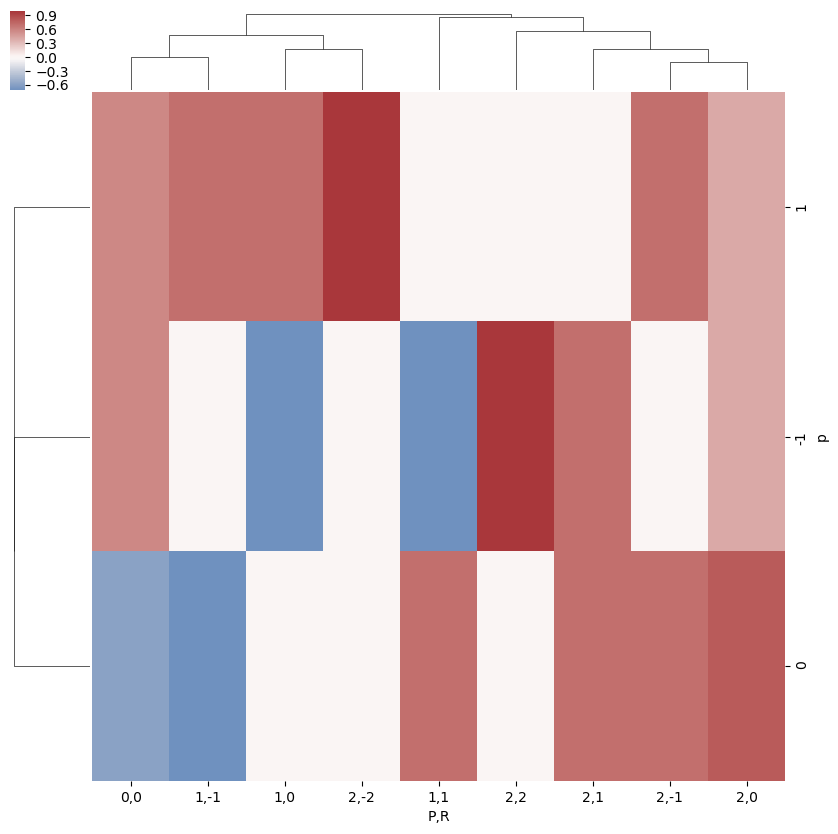

In [15]:
# A complementary visulization is to call directly the sns.clustermap plot, use clustering and plot by category labels - see https://seaborn.pydata.org/index.html
# (ep.lpPlot uses a modified version of this routine.)
snsMatMod.clustermap(daPlotpd.fillna(0), center=0, cmap="vlag", row_cluster=True, col_cluster=True)

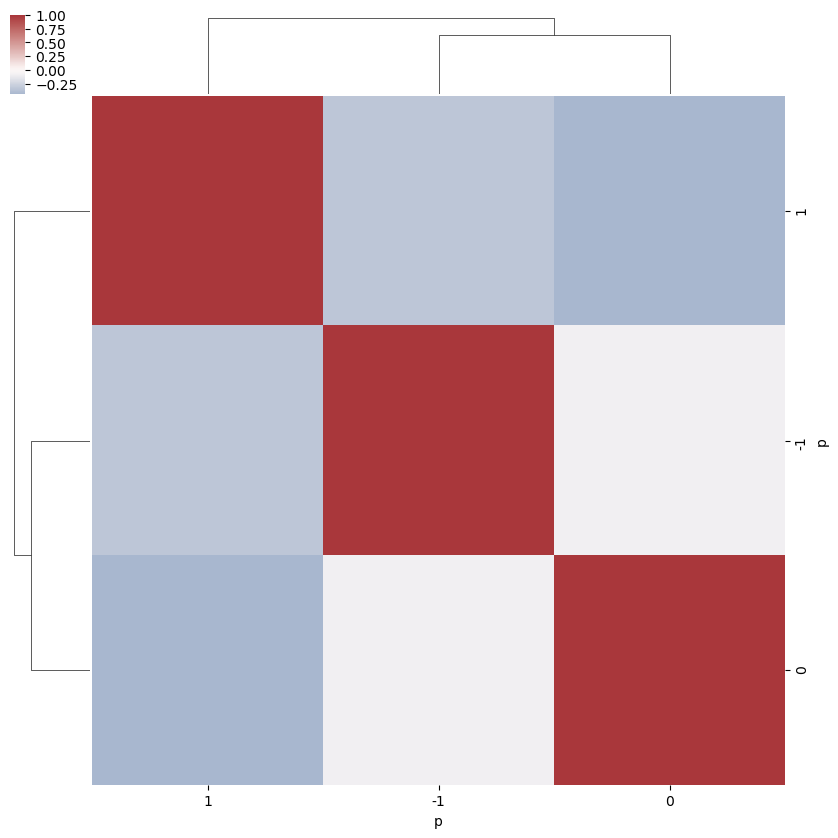

In [16]:
snsMatMod.clustermap(daPlotpd.fillna(0).T.corr(), center=0, cmap="vlag", row_cluster=True, col_cluster=True)

## $B_{L,M}$ term

The coupling of the partial wave pairs, $|l,m\rangle$ and $|l',m'\rangle$, into the observable set of $\{L,M\}$ is defined by a tensor contraction with two 3j terms.

\begin{equation}
B_{L,M}=(-1)^{m}\left(\frac{(2l+1)(2l'+1)(2L+1)}{4\pi}\right)^{1/2}\left(\begin{array}{ccc}
l & l' & L\\
0 & 0 & 0
\end{array}\right)\left(\begin{array}{ccc}
l & l' & L\\
-m & m' & M
\end{array}\right)
\end{equation}

(See notebook ePSproc_wigner3j_dataStructures_260220.ipynb on Bemo for additonal dev details)

Note that this term is equivalent, effectively, as the triple intergral over spherical harmonics (e.g. eqn. 3.119 in Zare):

\begin{equation}
\intop_{0}^{2\pi}\intop_{0}^{\pi}Y_{J_{3}M_{3}}(\theta,\phi)Y_{J_{2}M_{2}}(\theta,\phi)Y_{J_{1}M_{1}}(\theta,\phi)\sin\theta d\theta d\phi=\left(\frac{(2J_{1}+1)(2J_{2}+1)(2J_{3}+1)}{4\pi}\right)^{1/2}\left(\begin{array}{ccc}
J_{1} & J_{2} & J_{3}\\
0 & 0 & 0
\end{array}\right)\left(\begin{array}{ccc}
J_{1} & J_{2} & J_{3}\\
M_{1} & M_{2} & M_{3}
\end{array}\right)
\end{equation}


... or contraction over a pair of harmonics into a resultant harmonic (e.g. eqns. C.21, C.22 in Blum), and this is how the term arises in the derivation.

\begin{equation}
Y_{J_{1}M_{1}}(\theta,\phi)Y_{J_{2}M_{2}}(\theta,\phi)=\sum_{J_{3}M_{3}}\left(\frac{(2J_{1}+1)(2J_{2}+1)(2J_{3}+1)}{4\pi}\right)^{1/2}\left(\begin{array}{ccc}
J_{1} & J_{2} & J_{3}\\
0 & 0 & 0
\end{array}\right)\left(\begin{array}{ccc}
J_{1} & J_{2} & J_{3}\\
M_{1} & M_{2} & M_{3}
\end{array}\right)Y^*_{J_{3}M_{3}}(\theta,\phi)
\end{equation}

(Again, for more details on [see Wikipedia](https://en.wikipedia.org/wiki/3-j_symbol) and [Wolfram Mathworld](https://mathworld.wolfram.com/Wigner3j-Symbol.html).)

Note also some defns. use conjugate spherical harmonics, can convert as (Blum C.21):

\begin{equation}
\beta_{L,M}^{\mu_{i},\mu_{f}}Y_{LM}^{*}(\theta_{\hat{k}},\phi_{\hat{k}})=\beta_{L,-M}^{\mu_{i},\mu_{f}}(-1)^{M}Y_{L,-M}(\theta_{\hat{k}},\phi_{\hat{k}})\label{eq:sph-conj-conv}
\end{equation}


In [17]:
Lmax = 1
BLMtable = geomCalc.betaTerm(Lmax = Lmax, form = 'xdaLM').stack({'lSet':['l','lp','L'],'mSet':['m','mp','M']}).dropna('mSet',how='all').dropna('lSet',how='all')  # Output as stacked Xarray & drop NaNs where possible

In [18]:
BLMtable  #.sel({'l':1,'lp':1,'M':0})  # Print subset of terms with l=lp=1, M=0

<xarray.DataArray 'w3jStacked' (lSet: 5, mSet: 9)>
array([[        nan,         nan,         nan,         nan,  0.28209479,
                nan,         nan,         nan,         nan],
       [        nan,         nan,         nan, -0.28209479,  0.28209479,
        -0.28209479,         nan,         nan,         nan],
       [        nan,  0.28209479,         nan,         nan,  0.28209479,
                nan,         nan,  0.28209479,         nan],
       [        nan,         nan,  0.28209479,         nan,  0.28209479,
                nan,  0.28209479,         nan,         nan],
       [-0.30901936,  0.21850969, -0.12615663, -0.21850969,  0.25231325,
        -0.21850969, -0.12615663,  0.21850969, -0.30901936]])
Coordinates:
  * lSet     (lSet) MultiIndex
  - l        (lSet) int64 0 0 1 1 1
  - lp       (lSet) int64 0 1 0 1 1
  - L        (lSet) int64 0 1 1 0 2
  * mSet     (mSet) MultiIndex
  - m        (mSet) int64 -1 -1 -1 0 0 0 1 1 1
  - mp       (mSet) int64 -1 0 1 -1 0 1 -1 0 1
  - M        (mSet) int64 2 1 0 1 0 -1 0 -1 -2
Attributes:
    dataType:   betaTerm
    phaseCons:  {'phaseConvention': 'S', 'genMatEcons': {'negm': False}, 'EPR...

In [19]:
plotDimsRed = ['l', 'm', 'lp', 'mp']
xDim = {'LM':['L','M']}
# daPlot = BLMtable.unstack().stack({'LM':['L','M']})
# ep.lmPlot(w3jXcombMult.unstack().stack({'LM':['l','m']}), plotDims=['lp', 'L', 'mp', 'M'], xDim='LM', SFflag = False)
# daPlot, daPlotpd, legendList, gFig = ep.lmPlot(BLMtable.unstack().stack(xDim), plotDims=plotDimsRed, xDim=xDim, SFflag = False, squeeze = False)
# daPlot, daPlotpd, legendList, gFig = ep.lmPlot(BLMtable, plotDims=plotDimsRed, xDim=xDim)
# ep.lmPlot(w3jXcombMult.unstack(), plotDims=['lp', 'L', 'mp', 'M'], xDim='L', SFflag = False)

# daPlotpd = daPlot.unstack().stack(plotDim = plotDimsRed).to_pandas().dropna(axis = 1).T

C:\Users\femtolab\.conda\envs\ePSdev\lib\site-packages\xarray\core\nputils.py:215: RuntimeWarning:

All-NaN slice encountered



Plotting data (No filename), pType=r, thres=0.01, with Seaborn


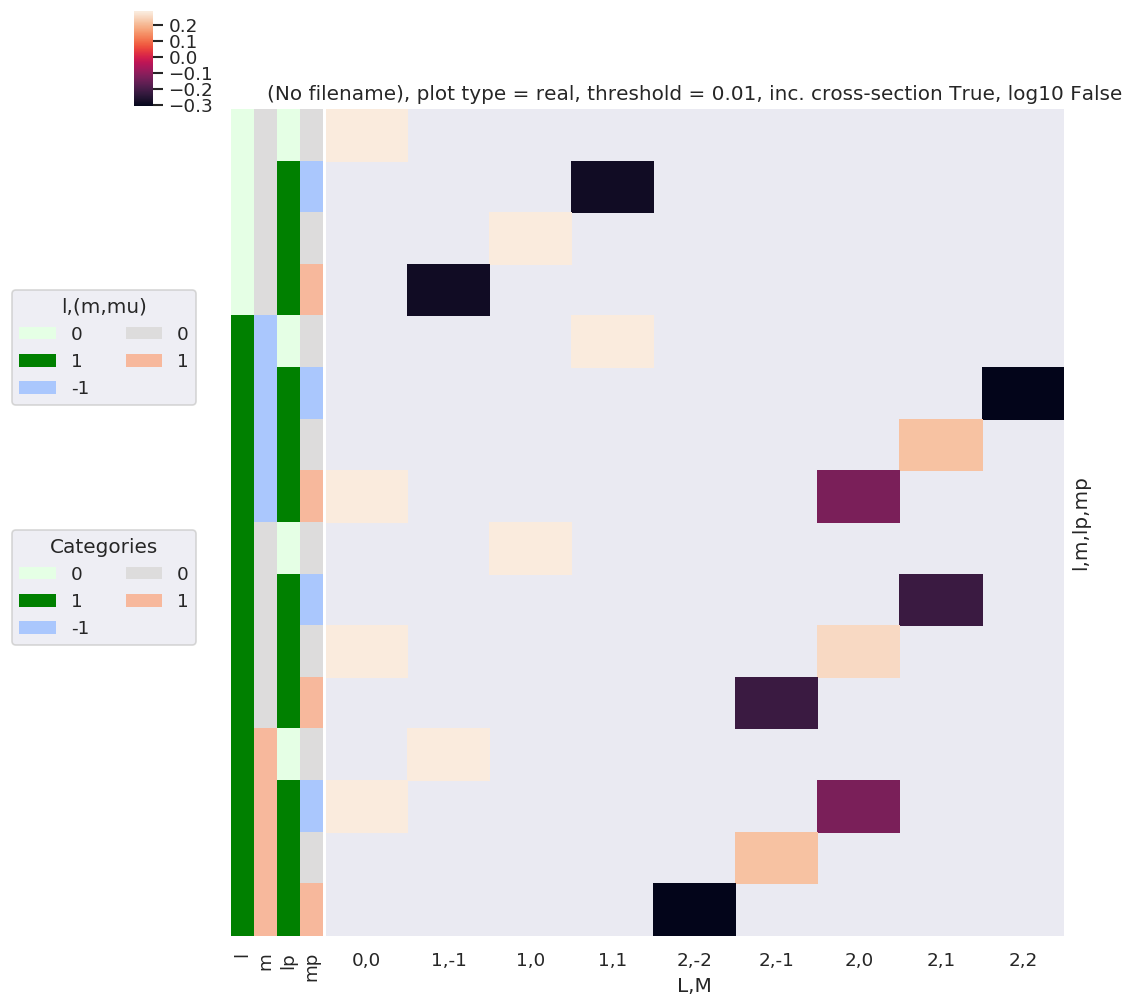

In [20]:
# daPlot, daPlotpd, legendList, gFig = ep.lmPlot(BLMtable.unstack().stack(xDim), plotDims=plotDimsRed, xDim=xDim, pType = 'r')
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(BLMtable, plotDims=plotDimsRed, xDim=xDim, pType = 'r')

In [21]:
daPlotpd

L                  0         1                             2           \
M                  0        -1         0         1        -2       -1   
l m  lp mp                                                              
0  0 0   0  0.282095       NaN       NaN       NaN       NaN      NaN   
     1  -1       NaN       NaN       NaN -0.282095       NaN      NaN   
         0       NaN       NaN  0.282095       NaN       NaN      NaN   
         1       NaN -0.282095       NaN       NaN       NaN      NaN   
1 -1 0   0       NaN       NaN       NaN  0.282095       NaN      NaN   
     1  -1       NaN       NaN       NaN       NaN       NaN      NaN   
         0       NaN       NaN       NaN       NaN       NaN      NaN   
         1  0.282095       NaN       NaN       NaN       NaN      NaN   
   0 0   0       NaN       NaN  0.282095       NaN       NaN      NaN   
     1  -1       NaN       NaN       NaN       NaN       NaN      NaN   
         0  0.282095       NaN       NaN       NaN       NaN      NaN   
         1       NaN       NaN       NaN       NaN       NaN -0.21851   
   1 0   0       NaN  0.282095       NaN       NaN       NaN      NaN   
     1  -1  0.282095       NaN       NaN       NaN       NaN      NaN   
         0       NaN       NaN       NaN       NaN       NaN  0.21851   
         1       NaN       NaN       NaN       NaN -0.309019      NaN   

L                                        
M                  0        1         2  
l m  lp mp                               
0  0 0   0       NaN      NaN       NaN  
     1  -1       NaN      NaN       NaN  
         0       NaN      NaN       NaN  
         1       NaN      NaN       NaN  
1 -1 0   0       NaN      NaN       NaN  
     1  -1       NaN      NaN -0.309019  
         0       NaN  0.21851       NaN  
         1 -0.126157      NaN       NaN  
   0 0   0       NaN      NaN       NaN  
     1  -1       NaN -0.21851       NaN  
         0  0.252313      NaN       NaN  
         1       NaN      NaN       NaN  
   1 0   0       NaN      NaN       NaN  
     1  -1 -0.126157      NaN       NaN  
         0       NaN      NaN       NaN  
         1       NaN      NaN       NaN

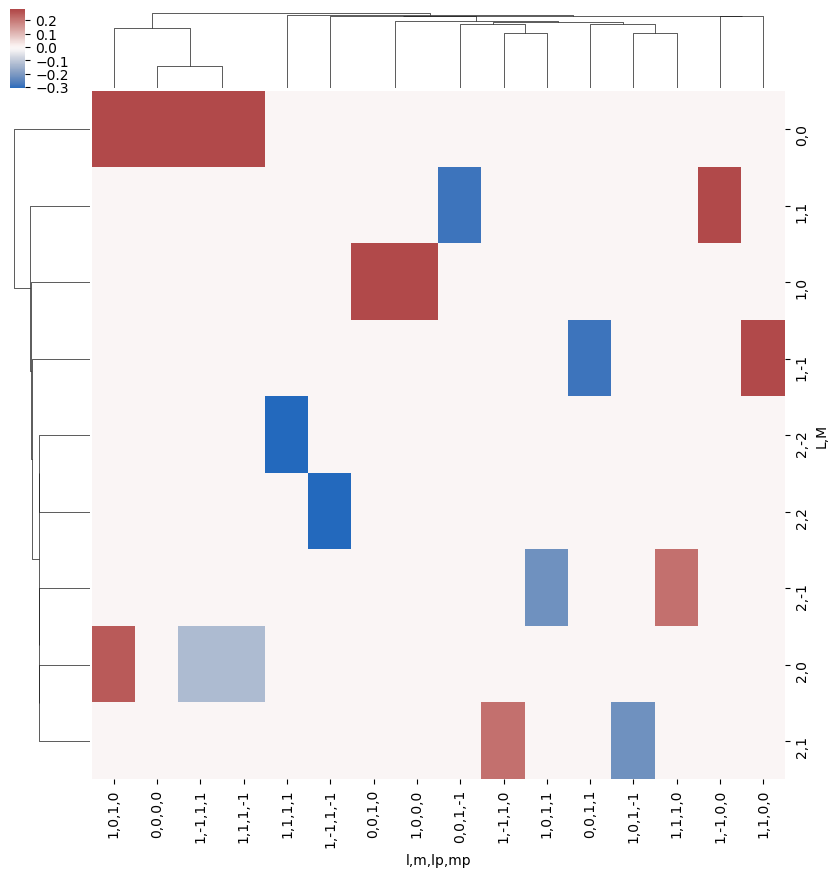

In [22]:
# A complementary visulization is to call directly the sns.clustermap plot, use clustering and plot by category labels - see https://seaborn.pydata.org/index.html
# (ep.lpPlot uses a modified version of this routine.)
snsMatMod.clustermap(daPlotpd.fillna(0).T, center=0, cmap="vlag", row_cluster=True, col_cluster=True)

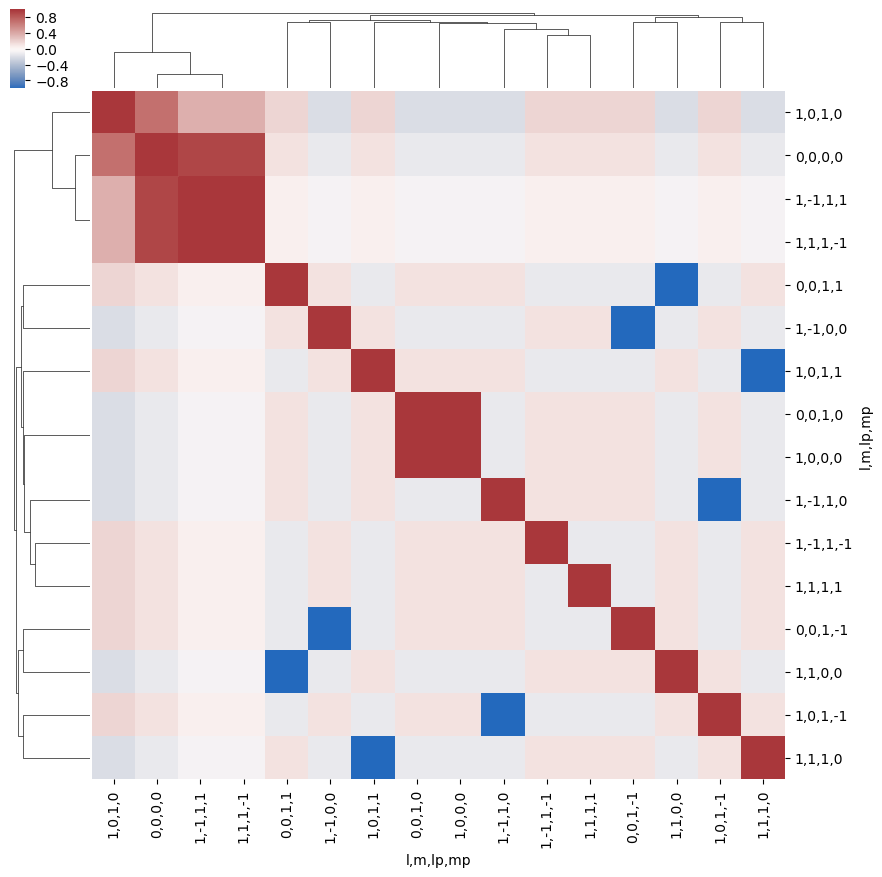

In [23]:
snsMatMod.clustermap(daPlotpd.fillna(0).T.corr(), center=0, cmap="vlag", row_cluster=True, col_cluster=True)

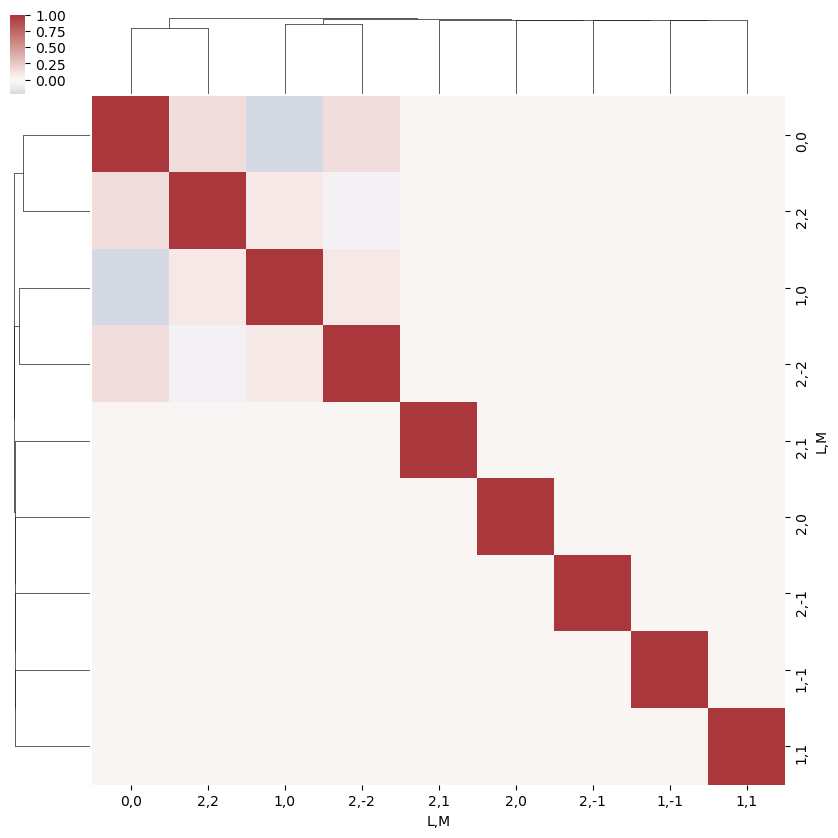

In [24]:
snsMatMod.clustermap(daPlotpd.fillna(0).corr(), center=0, cmap="vlag", row_cluster=True, col_cluster=True)

What do we learn here...?  This is a nice way to visualize the selection rules into the observable: for instance, only terms $l=l'$ and $m=-m'$ contribute to the overall photoinoization cross-section term ($L=0, M=0$). However, since these terms are fairly simply followed algebraically in this case, via the rules inherent in the 3j product, this is not particularly insightful. These visualizations will become more useful when dealing with real sets of matrix elements, and specific polarization geometries, which will further modulate the $B_{L,M}$ terms.

C:\Users\femtolab\.conda\envs\ePSdev\lib\site-packages\xarray\core\nputils.py:215: RuntimeWarning:

All-NaN slice encountered



Plotting data (No filename), pType=r, thres=0.01, with Seaborn


No handles with labels found to put in legend.


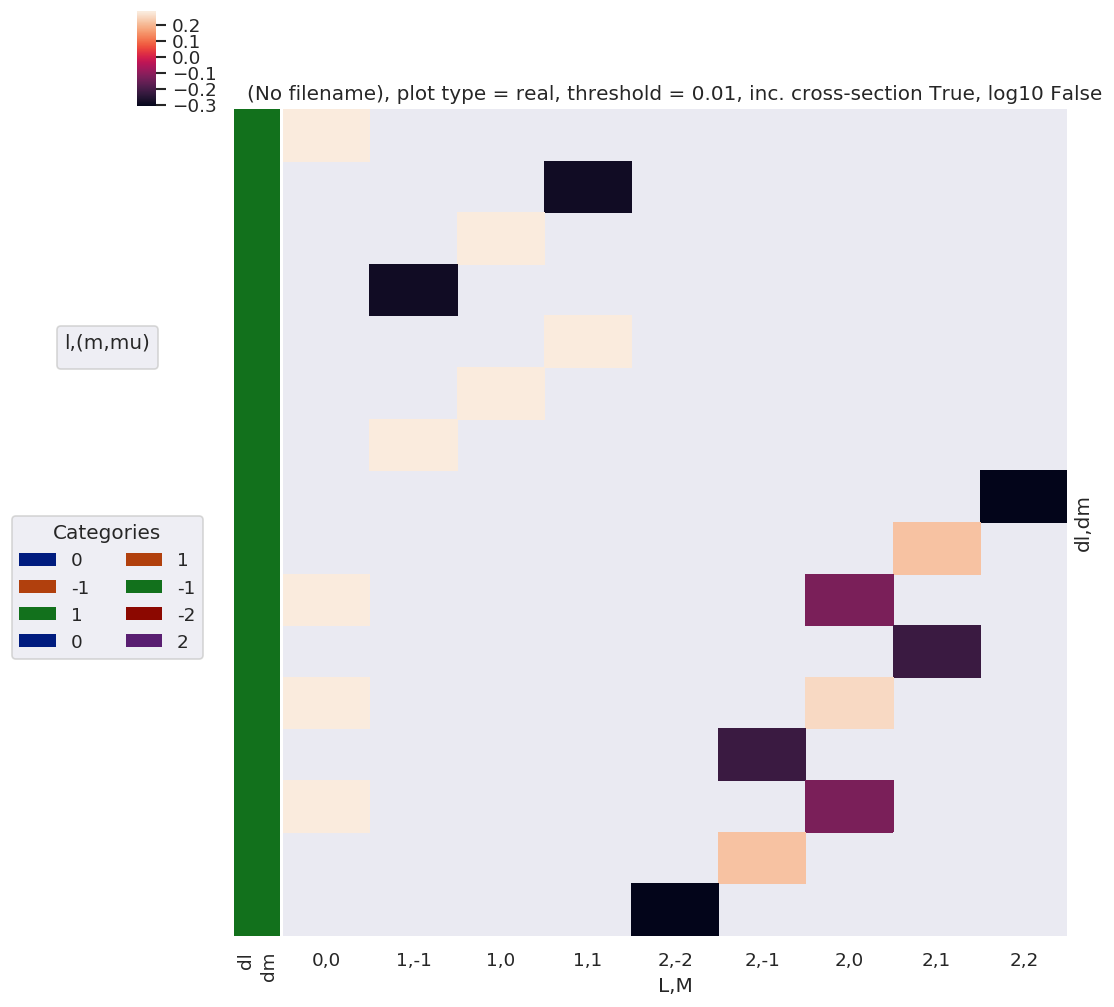

In [25]:
# PLOT AS A FN. of dl, dm... should just need to recalc dims or add a separate label for this?
# dl = BLMtable.l - BLMtable.lp
# dm = BLMtable.m - BLMtable.mp

BLMdeltas = BLMtable.unstack().stack({'LM':['L','M'], 'dl':['l','lp'], 'dm':['m','mp']})
dl = BLMdeltas.l - BLMdeltas.lp
dm = BLMdeltas.m - BLMdeltas.mp

# Set new dims & plot
BLMdeltas = BLMdeltas.assign_coords(dl=dl, dm=dm)  # This works, but not plotting correctly for some reason - maybe dim names?
plotDimsRed = ['dl','dm']
# BLMdeltas = BLMdeltas.assign_coords(dl=dl, dm=dm).rename({'dl':'l', 'dm':'m'})  # Hmm, same result - values present in daPlotpd not showing up here, or losing correlations...?
# plotDimsRed = ['l','m']
xDim = {'LM':['L','M']}
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(BLMdeltas, plotDims=plotDimsRed, xDim=xDim, pType = 'r')

In [26]:
daPlotpd

L             0         1                             2                     \
M             0        -1         0         1        -2       -1         0   
dl dm                                                                        
 0  0  0.282095       NaN       NaN       NaN       NaN      NaN       NaN   
-1  1       NaN       NaN       NaN -0.282095       NaN      NaN       NaN   
    0       NaN       NaN  0.282095       NaN       NaN      NaN       NaN   
   -1       NaN -0.282095       NaN       NaN       NaN      NaN       NaN   
 1 -1       NaN       NaN       NaN  0.282095       NaN      NaN       NaN   
    0       NaN       NaN  0.282095       NaN       NaN      NaN       NaN   
    1       NaN  0.282095       NaN       NaN       NaN      NaN       NaN   
 0  0       NaN       NaN       NaN       NaN       NaN      NaN       NaN   
   -1       NaN       NaN       NaN       NaN       NaN      NaN       NaN   
   -2  0.282095       NaN       NaN       NaN       NaN      NaN -0.126157   
    1       NaN       NaN       NaN       NaN       NaN      NaN       NaN   
    0  0.282095       NaN       NaN       NaN       NaN      NaN  0.252313   
   -1       NaN       NaN       NaN       NaN       NaN -0.21851       NaN   
    2  0.282095       NaN       NaN       NaN       NaN      NaN -0.126157   
    1       NaN       NaN       NaN       NaN       NaN  0.21851       NaN   
    0       NaN       NaN       NaN       NaN -0.309019      NaN       NaN   

L                         
M            1         2  
dl dm                     
 0  0      NaN       NaN  
-1  1      NaN       NaN  
    0      NaN       NaN  
   -1      NaN       NaN  
 1 -1      NaN       NaN  
    0      NaN       NaN  
    1      NaN       NaN  
 0  0      NaN -0.309019  
   -1  0.21851       NaN  
   -2      NaN       NaN  
    1 -0.21851       NaN  
    0      NaN       NaN  
   -1      NaN       NaN  
    2      NaN       NaN  
    1      NaN       NaN  
    0      NaN       NaN

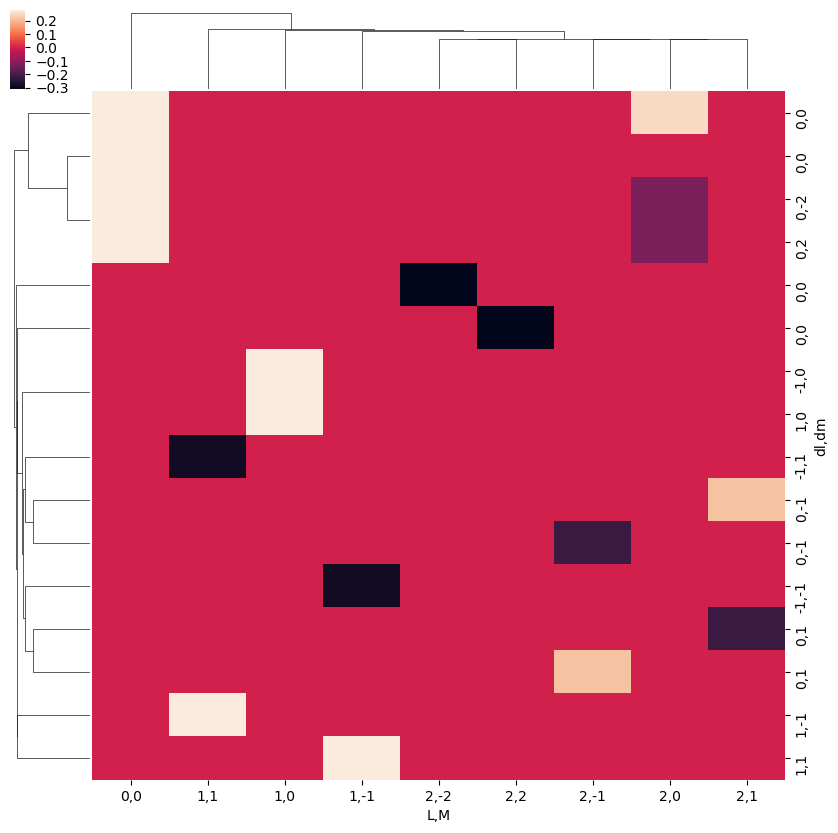

In [27]:
snsMatMod.clustermap(daPlotpd.fillna(0))

Note correlation of terms, with final $L$ and $M$ odd or even terms grouped according to odd or even $\Delta l$ and  $\Delta m$ respectively.

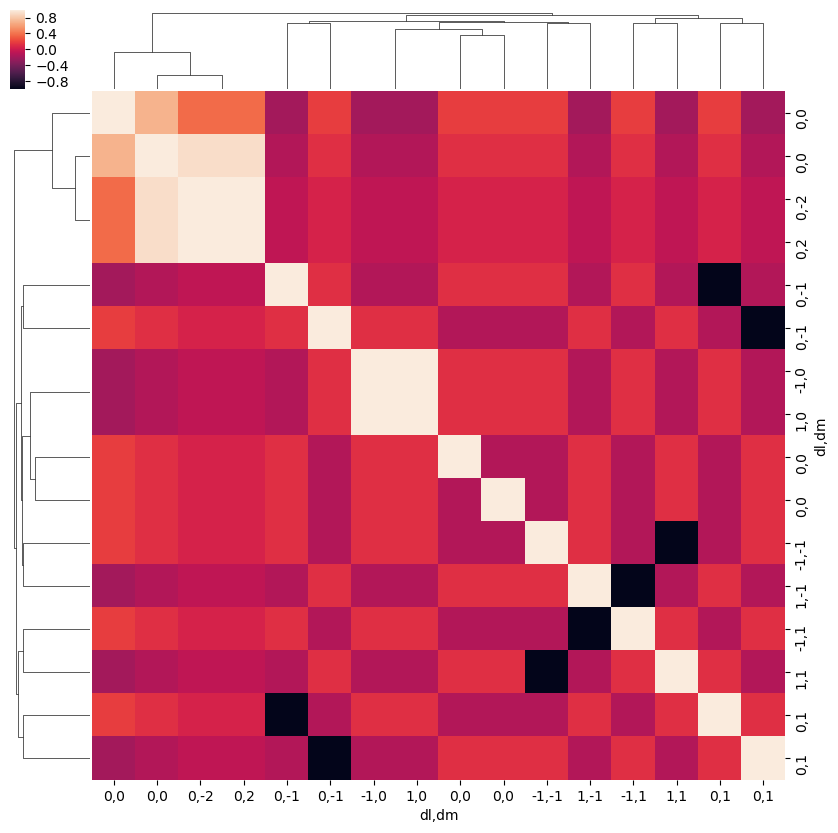

In [28]:
snsMatMod.clustermap(daPlotpd.fillna(0).T.corr())

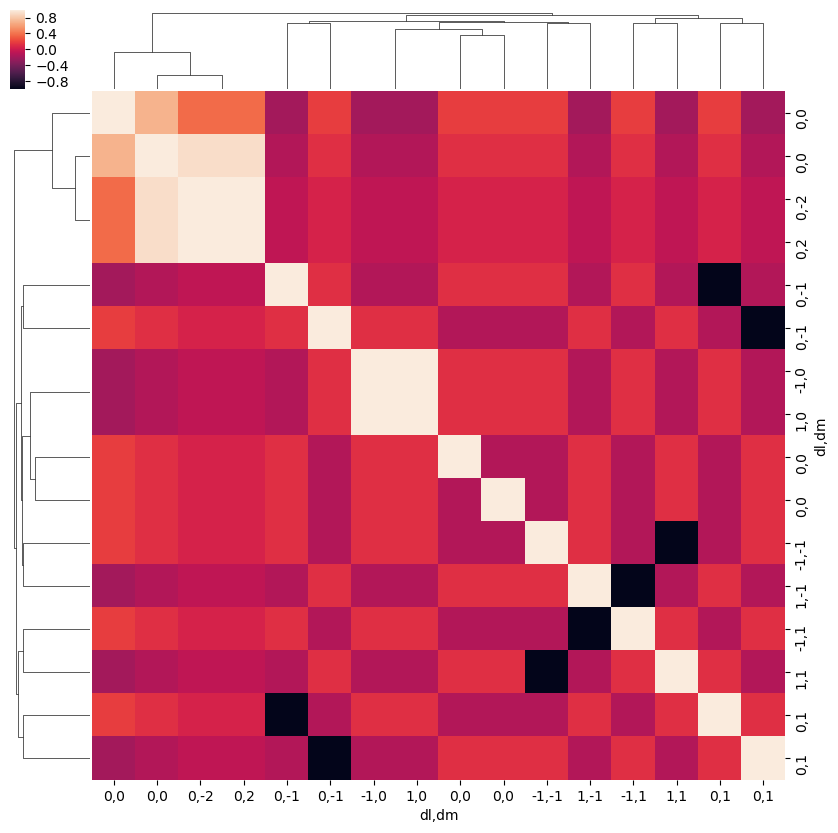

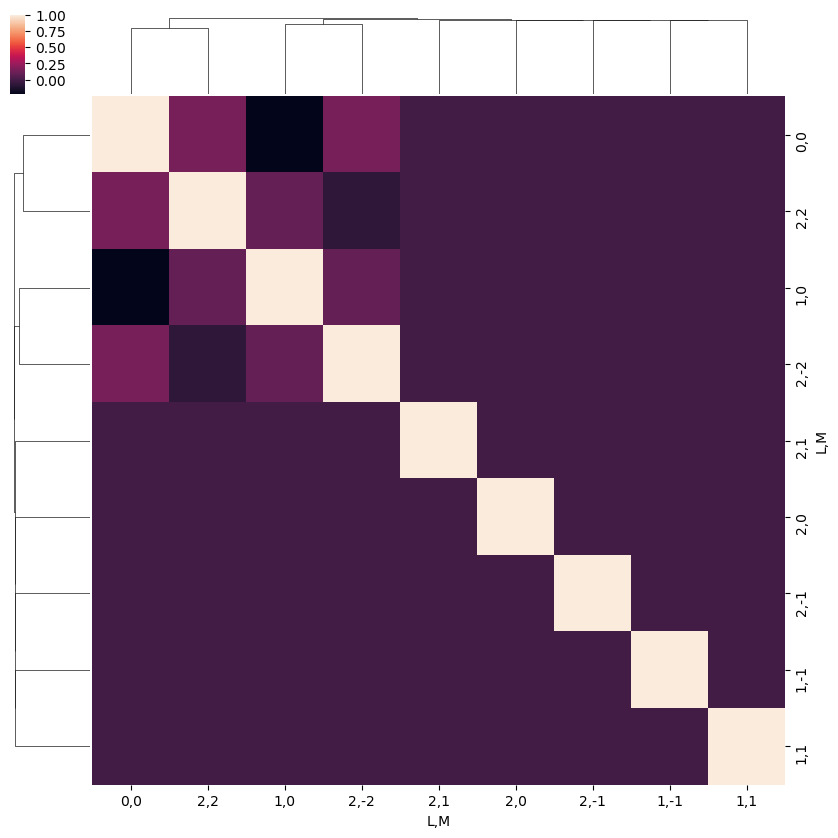

In [29]:
# Test correlation fns.
# This fails with NaNs present it seems
# ep.snsMatMod.clustermap(daPlot.dropna(dim='plotDim', how='all').dropna(dim='LM',how='all').fillna(0).to_pandas().T.corr())
# ep.snsMatMod.clustermap(daPlot.dropna(dim='plotDim', how='all').dropna(dim='LM',how='all').fillna(0).to_pandas().corr())
snsMatMod.clustermap(daPlotpd.fillna(0).T.corr())
snsMatMod.clustermap(daPlotpd.fillna(0).corr())

C:\Users\femtolab\.conda\envs\ePSdev\lib\site-packages\xarray\core\nputils.py:215: RuntimeWarning:

All-NaN slice encountered



Plotting data (No filename), pType=r, thres=0.01, with Seaborn


No handles with labels found to put in legend.


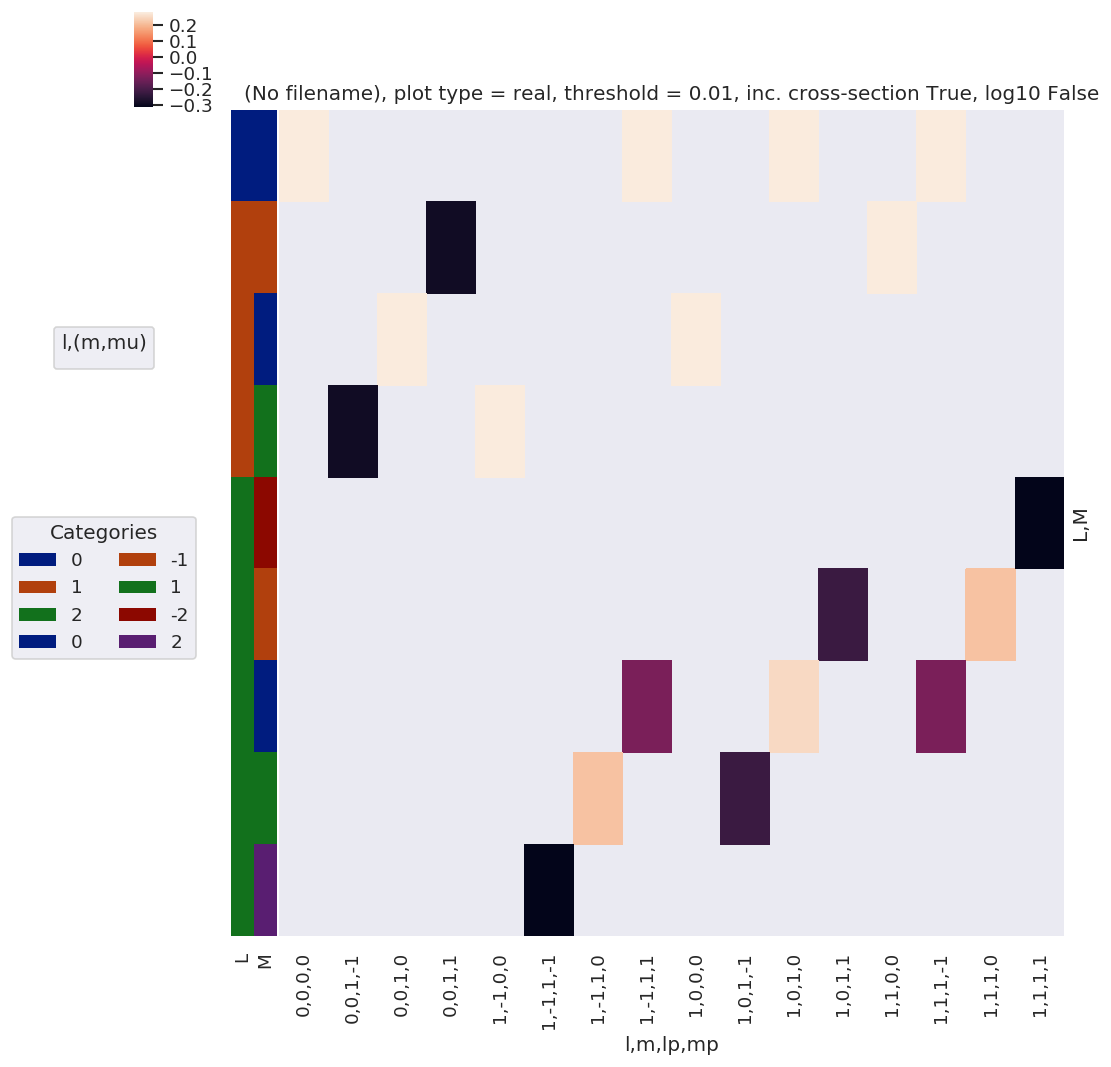

In [30]:
# Switch plotting dims
plotDimsRed = ['L','M']
xDim = {'llpmmp':['l', 'm', 'lp', 'mp']}
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(BLMtable, plotDims=plotDimsRed, xDim=xDim, mMax = 2, pType = 'r')

## $\Lambda$ Term

Define MF projection term, $\Lambda_{R',R}(R_{\hat{n}})$:

\begin{equation}
\Lambda_{R',R}(R_{\hat{n}})=(-1)^{(R')}\left(\begin{array}{ccc}
1 & 1 & P\\
\mu & -\mu' & R'
\end{array}\right)D_{-R',-R}^{P}(R_{\hat{n}})
\end{equation}

This is similar to the $E_{PR}$ term, and essentially rotates it into the MF by a set of rotations (Euler angles) defined by $R_{\hat{n}}$.

In [31]:
# Calculate MF projection terms, all QNs, for Euler angles corresponding to (z,x,y) cases
lambdaTerm, lambdaTable, lambdaD, QNs = geomCalc.MFproj(form = '2d')

# Output values as list, ['l', 'lp', 'P', 'mu', 'mup', 'Rp', 'R']
# print(lambdaTerm.shape)  
# print(np.c_[QNs[0:10,:], lambdaTerm[0:10,:]])

In [32]:
# Xarray form
lambdaTerm, lambdaTable, lambdaD, QNs = geomCalc.MFproj(form = 'xarray')

In [33]:
# Check values Xarray vs. 2d case for consistency
# TO DO

In [34]:
# In this case the QNs are left unstacked to facilitate multiplication across different terms - this fails for stacked (multindex) cases here.
lambdaTerm.dims

('Rp', 'l', 'lp', 'P', 'mu', 'mup', 'R', 'Labels')

Plotting data (No filename), pType=a, thres=0.01, with Seaborn
Plotting data (No filename), pType=phase, thres=0.01, with Seaborn


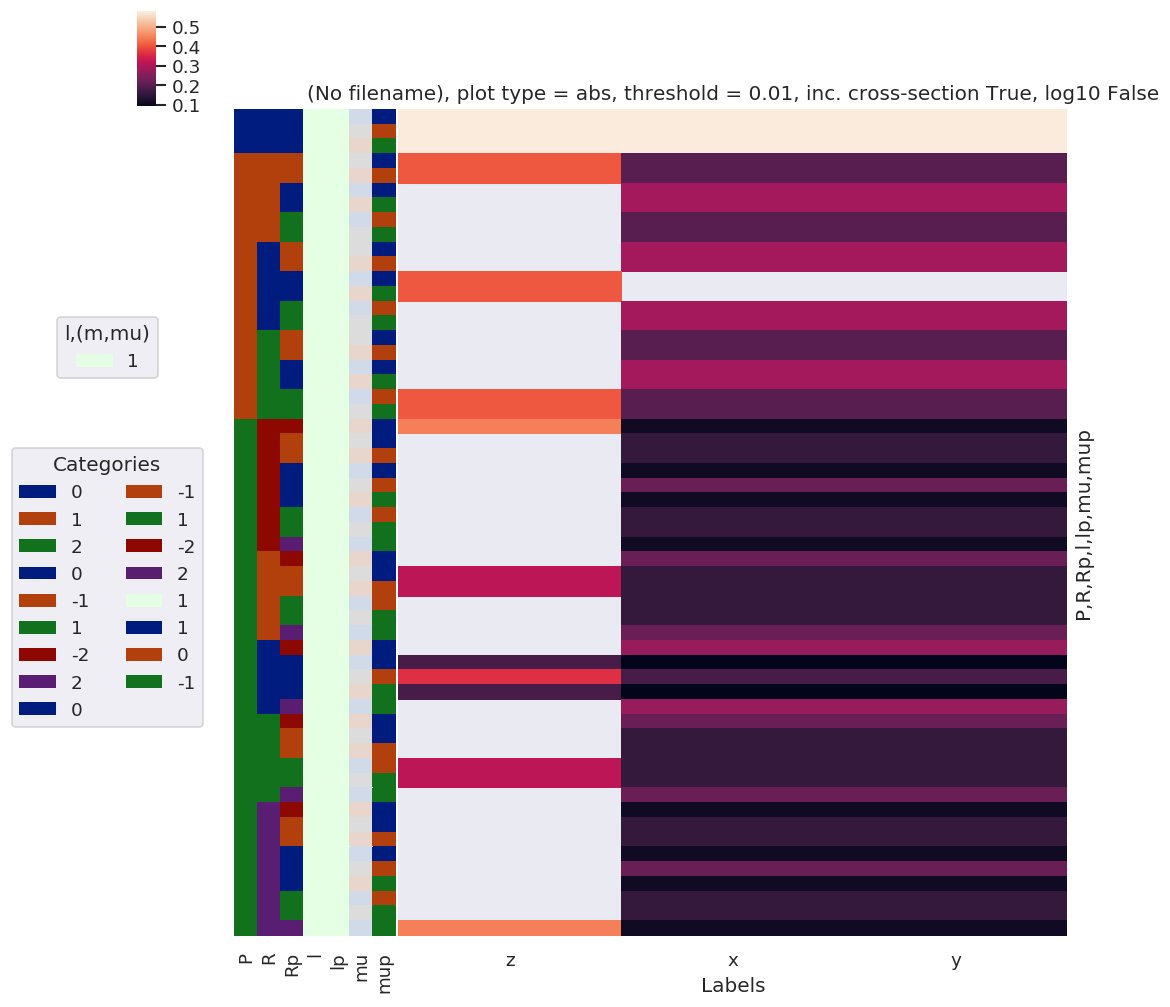

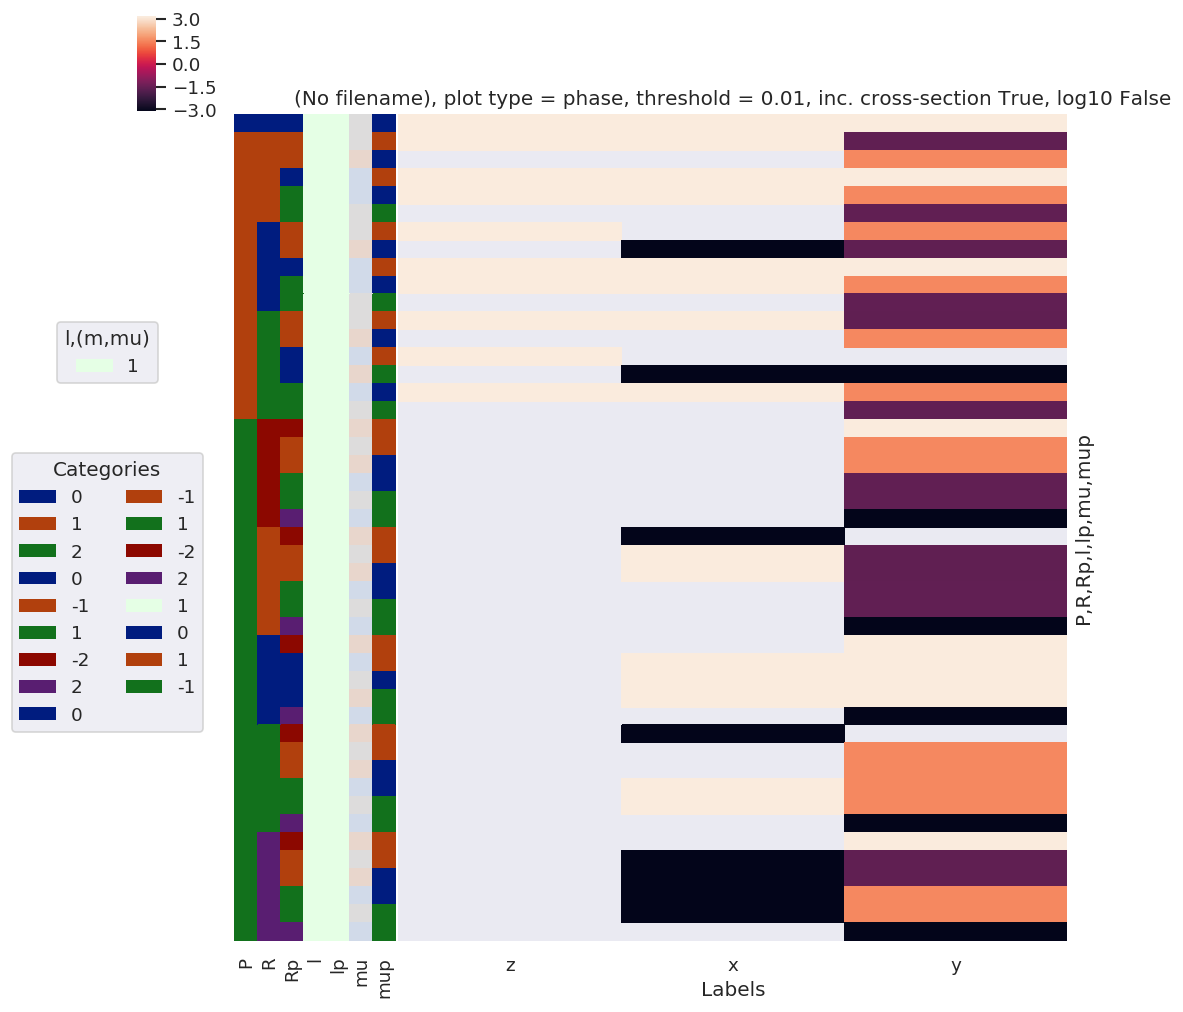

In [35]:
# Plot all QNs vs. Euler angles (by label)
xDim = 'Labels'
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(lambdaTerm, xDim=xDim, pType = 'a')   # Plot abs values
daPlotPhase, daPlotpdPhase, legendList, gFig = ep.lmPlot(lambdaTerm, xDim=xDim, pType = 'phase')   # Plot phase

In [36]:
daPlotpd

Labels                      z         x         y
P R  Rp l lp mu mup                              
0  0  0 1 1  -1  1   0.577350  0.577350  0.577350
              0  0   0.577350  0.577350  0.577350
              1 -1   0.577350  0.577350  0.577350
1 -1 -1 1 1   0  1   0.408248  0.204124  0.204124
              1  0   0.408248  0.204124  0.204124
      0 1 1  -1  1        NaN  0.288675  0.288675
              1 -1        NaN  0.288675  0.288675
      1 1 1  -1  0        NaN  0.204124  0.204124
              0 -1        NaN  0.204124  0.204124
   0 -1 1 1   0  1        NaN  0.288675  0.288675
              1  0        NaN  0.288675  0.288675
      0 1 1  -1  1   0.408248       NaN       NaN
              1 -1   0.408248       NaN       NaN
      1 1 1  -1  0        NaN  0.288675  0.288675
              0 -1        NaN  0.288675  0.288675
   1 -1 1 1   0  1        NaN  0.204124  0.204124
              1  0        NaN  0.204124  0.204124
      0 1 1  -1  1        NaN  0.288675  0.288675
              1 -1        NaN  0.288675  0.288675
      1 1 1  -1  0   0.408248  0.204124  0.204124
              0 -1   0.408248  0.204124  0.204124
2 -2 -2 1 1   1  1   0.447214  0.111803  0.111803
     -1 1 1   0  1        NaN  0.158114  0.158114
              1  0        NaN  0.158114  0.158114
      0 1 1  -1  1        NaN  0.111803  0.111803
              0  0        NaN  0.223607  0.223607
              1 -1        NaN  0.111803  0.111803
      1 1 1  -1  0        NaN  0.158114  0.158114
              0 -1        NaN  0.158114  0.158114
      2 1 1  -1 -1        NaN  0.111803  0.111803
  -1 -2 1 1   1  1        NaN  0.223607  0.223607
     -1 1 1   0  1   0.316228  0.158114  0.158114
              1  0   0.316228  0.158114  0.158114
      1 1 1  -1  0        NaN  0.158114  0.158114
              0 -1        NaN  0.158114  0.158114
      2 1 1  -1 -1        NaN  0.223607  0.223607
   0 -2 1 1   1  1        NaN  0.273861  0.273861
      0 1 1  -1  1   0.182574  0.091287  0.091287
              0  0   0.365148  0.182574  0.182574
              1 -1   0.182574  0.091287  0.091287
      2 1 1  -1 -1        NaN  0.273861  0.273861
   1 -2 1 1   1  1        NaN  0.223607  0.223607
     -1 1 1   0  1        NaN  0.158114  0.158114
              1  0        NaN  0.158114  0.158114
      1 1 1  -1  0   0.316228  0.158114  0.158114
              0 -1   0.316228  0.158114  0.158114
      2 1 1  -1 -1        NaN  0.223607  0.223607
   2 -2 1 1   1  1        NaN  0.111803  0.111803
     -1 1 1   0  1        NaN  0.158114  0.158114
              1  0        NaN  0.158114  0.158114
      0 1 1  -1  1        NaN  0.111803  0.111803
              0  0        NaN  0.223607  0.223607
              1 -1        NaN  0.111803  0.111803
      1 1 1  -1  0        NaN  0.158114  0.158114
              0 -1        NaN  0.158114  0.158114
      2 1 1  -1 -1   0.447214  0.111803  0.111803

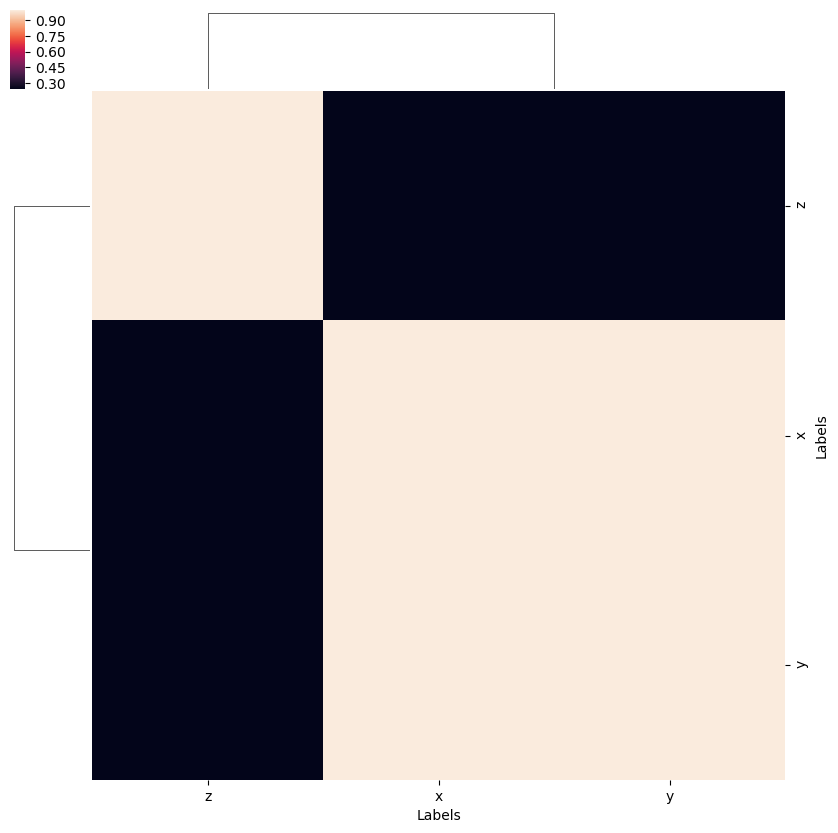

In [37]:
# Test correlation fns.
# ep.snsMatMod.clustermap(daPlotpd.fillna(0).T.corr())  # This currently failing with NaNs or inf?
snsMatMod.clustermap(daPlotpd.fillna(0).corr())

Here the separation of $z$ polarization, from the mixed $(x,y)$ case, in spherical functions, is clear.

## $\beta_{L,M}^{MF}$ rewrite

The various terms defined above can be used to redefine the full MF observables, expressed as a set of $\beta_{L,M}$ coefficients.

This is explored in pt 2...